# Rock Paper Scissors - AI
## Model training

### Imports

In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *
from image_processing import *

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.18.0
Keras version:  3.6.0
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


In [2]:
from PIL import Image
def resize_dataset(dataset_path, classes):
    # Resize all images in the dataset to 128x128
    for folder in os.listdir(dataset_path):
        for class_name in classes:
            class_folder = os.path.join(dataset_path, folder, class_name)
            for image in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image)
                img = Image.open(image_path)
                img = img.resize((128, 128))
                img.save(image_path)

### Dataset preprocessing

In [3]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'src_data')
# src_data contains the original data from the Kaggle dataset together with the augmented data from 'resized_images'
dataset_dir = os.path.join(local_dir, 'dataset_rgb_128')
models_dir = os.path.join(local_dir, 'models_rgb_128')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

classes = ['rock', 'paper', 'scissors']

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir)
    resize_dataset(dataset_dir, classes)

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')
  

./dataset_rgb_128\train
    - rock: 1911 images
    - paper: 1927 images
    - scissors: 1944 images
./dataset_rgb_128\val
    - rock: 239 images
    - paper: 241 images
    - scissors: 243 images
./dataset_rgb_128\test
    - rock: 239 images
    - paper: 241 images
    - scissors: 243 images


In [4]:
check_for_duplicates_in_dataset('./dataset_rgb_128')

No duplicates found in dataset
7228 files found in dataset


### Data augmentation

Found 5782 images belonging to 3 classes.
Found 723 images belonging to 3 classes.
Found 723 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


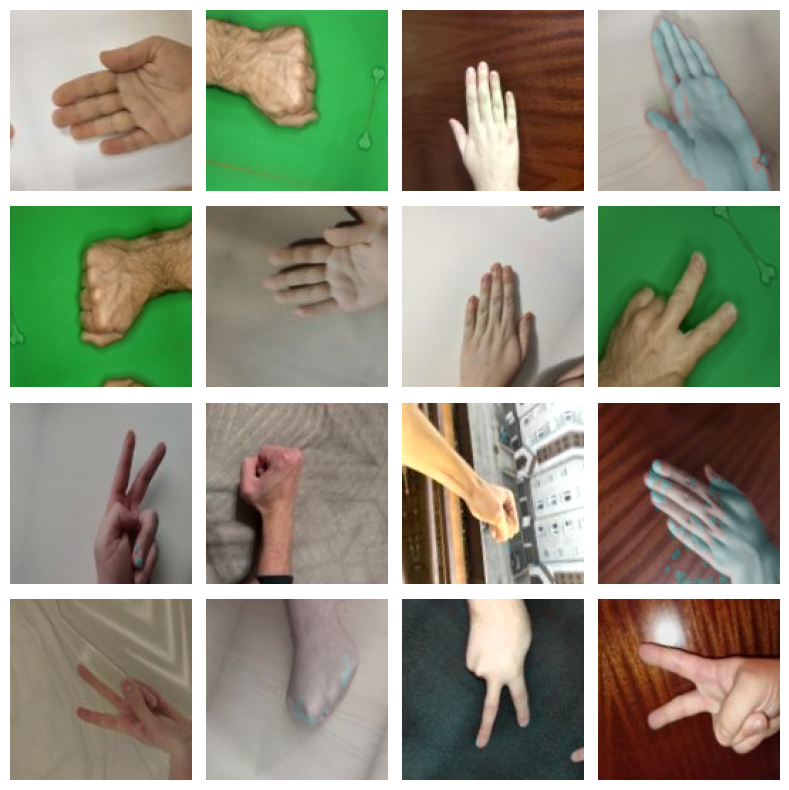

In [5]:
# Image target size
img_rows, img_cols = 128, 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=random_color_augmentation)


validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    zoom_range=[0.9, 1.1],
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

plot_grid_from_generator(train_generator, 4, 4)

### Model CNN

### Training

In [6]:
EPOCHS = 100
MODEL_NAME = 'rgb_128_larger_no_early_stopping'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=10,
    mode='max',
    restore_best_weights=True)

hist_dict = compile_and_train_model(
    create_model_func=build_cnn_medium_large_padding_same,
    create_model_args={'input_shape' : (128, 128, 3), 'num_classes' :3},
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'], 
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=EPOCHS,
    models_dir=models_dir,
    model_name=MODEL_NAME,
    callbacks=[checkpoint_callback, csvlogger_callback])



c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - acc: 0.4491 - loss: 1.0352 - val_acc: 0.4869 - val_loss: 1.0637
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - acc: 0.6267 - loss: 0.7854 - val_acc: 0.5602 - val_loss: 0.9446
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - acc: 0.6983 - loss: 0.6821 - val_acc: 0.7082 - val_loss: 0.6516
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - acc: 0.7731 - loss: 0.5405 - val_acc: 0.5892 - val_loss: 1.0933
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 44s 242ms/step - acc: 0.8038 - loss: 0.4819 - val_acc: 0.7483 - val_loss: 0.7368
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - acc: 0.8024 - loss: 0.4837 - val_acc: 0.7911 - val_loss: 0.4958
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - acc: 0.8382 - loss: 0.4119 - val_acc: 0.8437 - val_loss: 0.3610
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 47s 257ms/step - acc: 0.8488 - loss: 0.3724 - val_acc: 0.8811 - val_loss: 0.3094
Epoch 9/100
181/181 ━━━━

<Figure size 640x480 with 0 Axes>

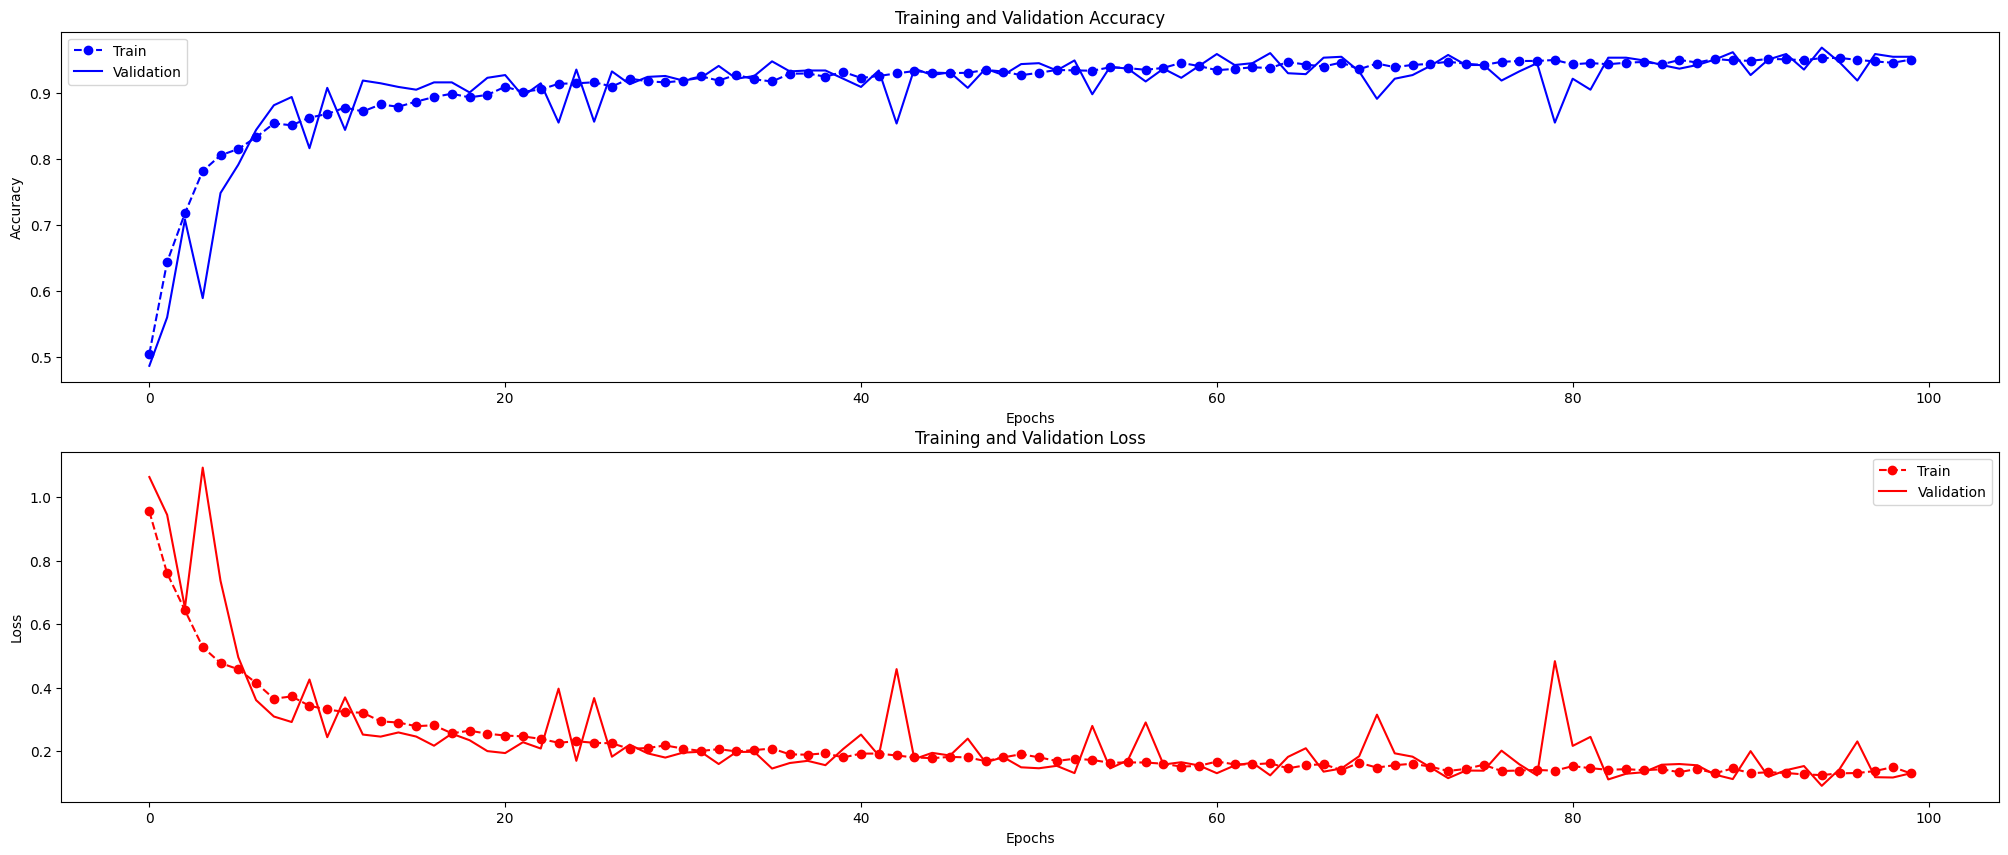

In [7]:
plot_accuracy_and_loss(hist_dict)

In [8]:
model = tf.keras.models.load_model(os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'))
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.9688 - loss: 0.0779
Test accuracy: 0.97
Test loss: 0.09
